In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report

RANDOM_STATE = 42
DATA_PATH = "kasha_data/exercise_2_shap.csv"       # dataset location
LABEL_COL = "adherence_predicted"       # binary target (0/1)

FEATURE_COLS = [
   "num_past_iits", "prev_iit_status", "past_encounters",
    "CD4_Count", "Viral_Load", "Current_WHO_HIV_Stage",
    "time_since_diagnosis_at_scheduled_appointment",
    "age_at_encounter", "gender", "Current Regimen Line",
    "TPT Outcome", "NCDs", "Establishment"
]

In [3]:
def load_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if LABEL_COL not in df.columns:
        raise ValueError(f"Label column '{LABEL_COL}' not found in dataset.")
    return df

def thin_to_features(df: pd.DataFrame) -> pd.DataFrame:
    # Keep only curated features + label; ignore any that might be missing
    present = [c for c in FEATURE_COLS if c in df.columns]
    missing = [c for c in FEATURE_COLS if c not in df.columns]
    if missing:
        print(f"[info] missing features not in dataset (skipped): {missing}")
    if len(present) < 8:
        raise ValueError(f"Too few selected features present ({len(present)}). Expected up to 15.")
    cols = present + [LABEL_COL]
    return df[cols].copy()

def prepare_xy(df: pd.DataFrame):
    X = df.drop(columns=[LABEL_COL], errors="ignore")
    y = df[LABEL_COL].astype(int)

    cat_cols = [c for c in X.columns if X[c].dtype == "object"]
    num_cols = [c for c in X.columns if c not in cat_cols]
    return X, y, num_cols, cat_cols

def build_model(num_cols, cat_cols) -> Pipeline:
    preproc = ColumnTransformer(
        transformers=[
            ("num", SimpleImputer(strategy="most_frequent"), num_cols),
            ("cat", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ohe",  OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
            ]), cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=True,
    )

    clf = RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )

    pipe = Pipeline(steps=[
        ("preproc", preproc),
        ("rf", clf),
    ])
    return pipe

def print_metrics(y_true, y_pred, header="Test Metrics"):
    print(f"\n=== {header} ===")
    pr, rc, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    print(f"Macro  P: {pr:.3f} | R: {rc:.3f} | F1: {f1:.3f}")
    pr_w, rc_w, f1_w, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted", zero_division=0
    )
    print(f"Weight P: {pr_w:.3f} | R: {rc_w:.3f} | F1: {f1_w:.3f}")
    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred, zero_division=0))

def train_and_eval(df: pd.DataFrame):
    X, y, num_cols, cat_cols = prepare_xy(df)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
    )

    pipeline = build_model(num_cols, cat_cols)
    pipeline.fit(X_train, y_train)

    # Evaluate on TEST set
    y_pred = pipeline.predict(X_test)
    print_metrics(y_test, y_pred, header="Test Metrics")

    preproc = pipeline.named_steps["preproc"]
    try:
        feature_names = preproc.get_feature_names_out()
    except Exception:
        feature_names = np.array(num_cols + [f"{c}__OHE" for c in cat_cols])

    return pipeline, X_train, X_test, y_train, y_test, feature_names


In [4]:
df_raw = load_data(DATA_PATH)
df = thin_to_features(df_raw)

pipeline, X_train, X_test, y_train, y_test, feature_names = train_and_eval(df)




=== Test Metrics ===
Macro  P: 0.749 | R: 0.686 | F1: 0.666
Weight P: 0.748 | R: 0.688 | F1: 0.667

Classification report:

              precision    recall  f1-score   support

           0       0.63      0.94      0.75        63
           1       0.87      0.44      0.58        62

    accuracy                           0.69       125
   macro avg       0.75      0.69      0.67       125
weighted avg       0.75      0.69      0.67       125



#### **SHAP Analysis**

In [5]:
import shap


#CREATING & EXECUTING SHAP EXPLAINER    

# Extract the trained model
rf_model = pipeline.named_steps["rf"]

# Create SHAP explainer (TreeExplainer is perfect for tree models)
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values on test data
X_preprocessed = pipeline.named_steps["preproc"].transform(X_test)
shap_values = explainer.shap_values(X_preprocessed)


/home/linet/Documents/KASHA-Interview-Assignment/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Global Explainability (Overall Feature Importance)**

In [16]:


# Handle different SHAP versions
if shap_values.ndim == 3:
    shap_values_class1 = shap_values[:, :, 1]
else:
    shap_values_class1 = shap_values[1]


**Global Feature Importance (aggregated insights)**

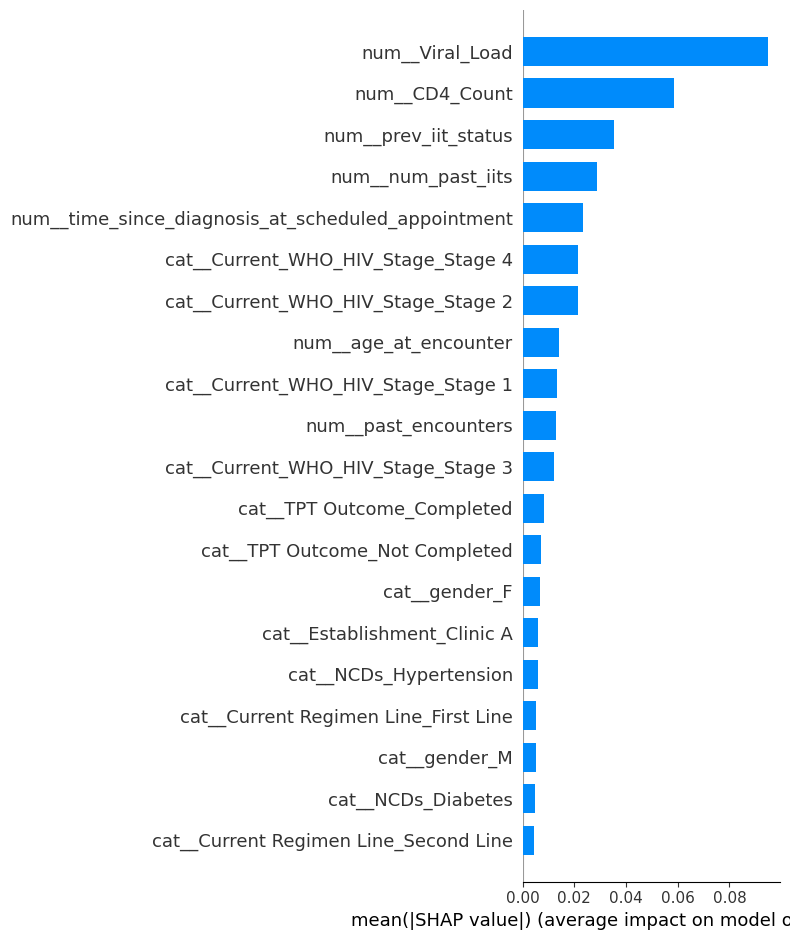

In [17]:
shap.summary_plot(
    shap_values_class1,
    X_preprocessed,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)



Viral_Load : The most influential predictor. Viral load strongly impacts the model’s output — higher viral load likely increases the risk of LFTU
prev_iit_status: Previous interruption-in-treatment status is a strong predictor — prior interruptions increase future risk.

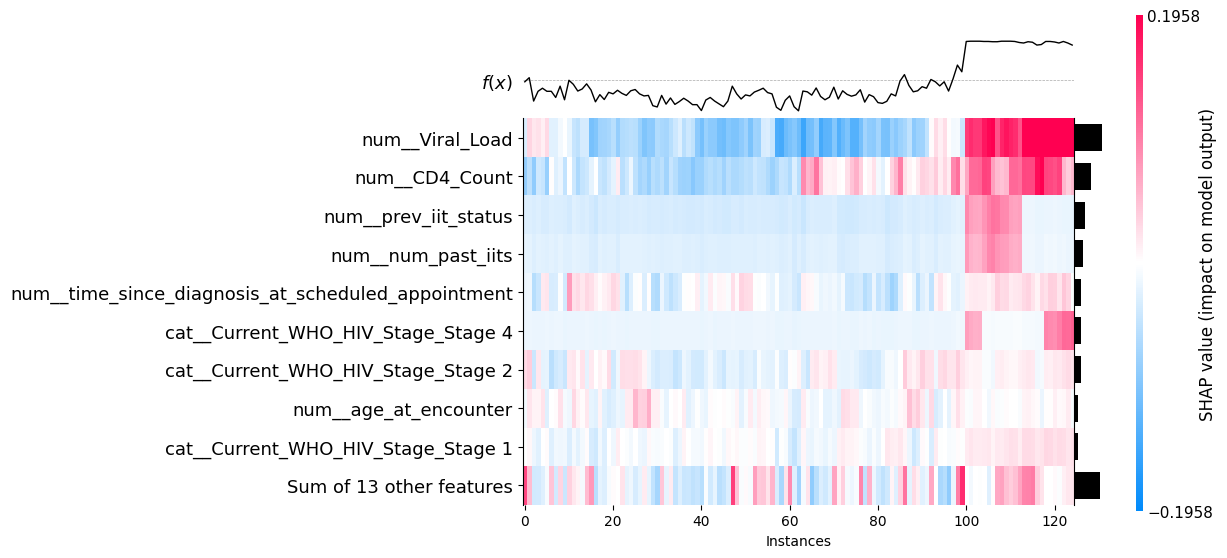

<Axes: xlabel='Instances'>

In [18]:
shap.plots.heatmap(
    shap.Explanation(
        values=shap_values_class1,
        base_values=explainer.expected_value[1] if hasattr(explainer.expected_value, "__len__") else explainer.expected_value,
        data=X_preprocessed,
        feature_names=feature_names
    )
)


   Feature	                                             Pattern	                                                                         Meaning
Viral_Load	                                    Mostly red on the right side (high SHAP values)	               High viral load consistently increases predictednon-adherence
CD4_Count	                                    Mostly blue on the left (low SHAP values)	                     Higher CD4 counts lower the risk of non-adherence
prev_iit_status	                              Red toward high f(x) patients	                                 Past treatment interruption (IIT) increases non-adherenceikelihood
num_past_iits	                                Similar trend	                                                More past interruptions → higher non-adherence
time_since_diagnosis_at_scheduled_appointment	Mixed (alternating red/blue)	                                 Effect varies; no consistent pattern across all patients
Current_WHO_HIV_Stage_4	                        Some red clusters	                                             Stage 4 tends to increase non-adherence risk
Current_WHO_HIV_Stage_2	                        Mostly blue	                                                   Associated with lower non-adherence risk
age_at_encounter	                            Weak pattern	                                                   Age has minor and inconsistent influence

**Beeswarm (summary) plot**

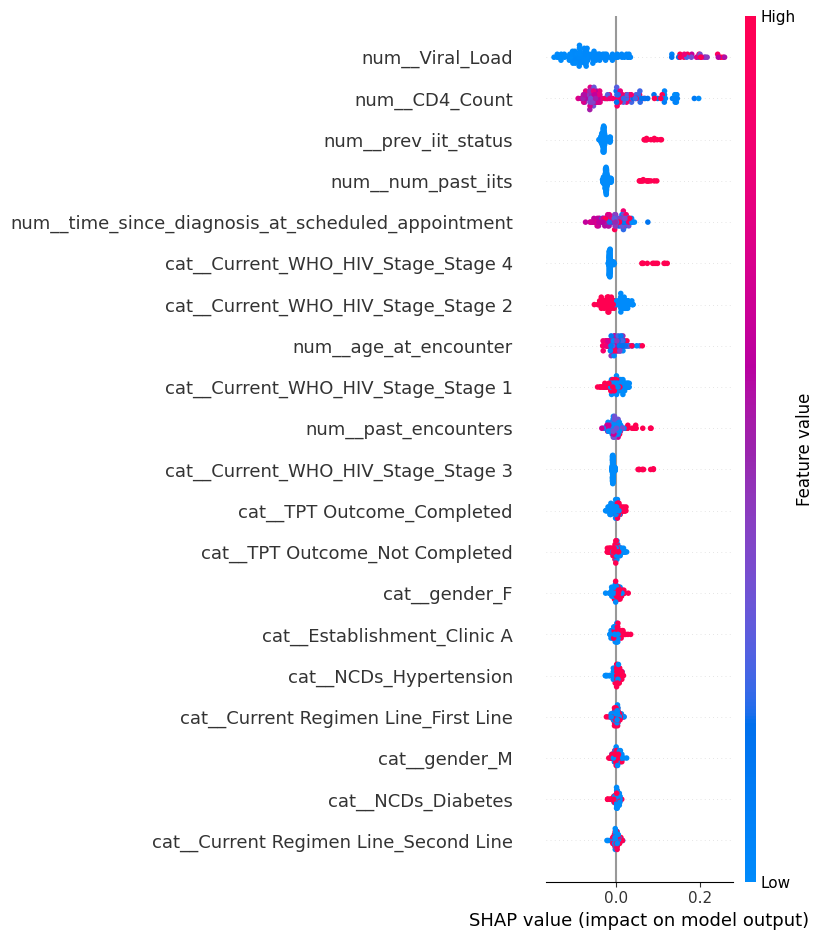

In [9]:
shap.summary_plot(
    shap_values_class1,
    X_preprocessed,
    feature_names=feature_names,
    show=True
)


*Viral_Load* : Higher viral load (red points) tends to increase the model output indicating higher risk of non-adherence.

*Cd4_counts*: Lower CD4 counts: (blue points) tend to increase predictions (move to the right) — consistent with CD4 being a measure of immune suppression.

*prev_iit_status*: Prior IIT (interruption in treatment) status influences outcomes — higher or positive values (red) push predictions upward, suggesting higher risk.


*Current_WHO_HIV_Stage_4* : Being in Stage 4 (advanced disease) strongly increases model output — high risk.
*age_at_encounter* : Slight effect — older age (red) may increase model output marginally.
*TPT_Outcome_Completed / Not Completed*: Completing TPT (tuberculosis preventive therapy) tends to lower predictions (blue points toward left), while not completing increases them

*num__prev_iit_status*: More past interruptions (red) increase model output — likely negative outcome association.
*num_past_iits*: More past interruptions (red) increase model output — likely negative outcome association.

*NCDs_Hypertension / Diabetes*: Having these comorbidities (red) might slightly increase risk.

**Aggregated numeric summary**

In [10]:

shap_importance = np.abs(shap_values_class1).mean(axis=0)
shap_ranking = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_SHAP": shap_importance
}).sort_values("mean_abs_SHAP", ascending=False)

shap_ranking.head(10)


,feature,mean_abs_SHAP
4,num__Viral_Load,0.094803
3,num__CD4_Count,0.058417
1,num__prev_iit_status,0.035199
0,num__num_past_iits,0.028755
5,num__time_since_diagnosis_at_scheduled_appoint...,0.023419
10,cat__Current_WHO_HIV_Stage_Stage 4,0.021459
8,cat__Current_WHO_HIV_Stage_Stage 2,0.021233
6,num__age_at_encounter,0.013964
7,cat__Current_WHO_HIV_Stage_Stage 1,0.013412
2,num__past_encounters,0.012956


**Dependence plot for Feature Specific Analysis:Interaction (2D dependence) plot**

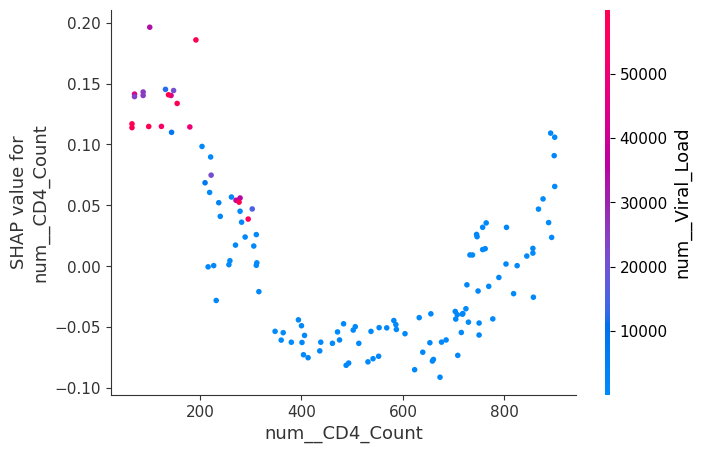

In [ ]:
# 1. CD4 and viral load
shap.dependence_plot("num__CD4_Count", shap_values_class1, X_preprocessed, feature_names=feature_names, interaction_index="num__Viral_Load")




Key Findings:
Low CD4 Count Significantly Increases Risk (High SHAP) of lFTU:

Clients with very low CD4 Counts (roughly below 250) have the highest positive SHAP values, clustering around 0.10 to 0.20. This indicates that a low CD4 count is a strong indicator for increased predicted risk (of poor adherence).

Within this low CD4 range, the highest risk points (pink/red) are associated with a high Viral Load (above 50,000). The model interprets the combination of a very low CD4 count and a high viral load as the highest risk factor in this plot.

High CD4 Count Decreases Risk (Low SHAP):

As the CD4 Count increases (above 400), the SHAP values become negative (down to -0.10), indicating that a high CD4 Count decreases the predicted risk. This is medically sound, as a higher CD4 count signifies a stronger immune system.

T**he "U" Shape:**

The overall plot shows a characteristic U-shape. Both extremely low CD4 counts (left side) and moderately high CD4 counts (right side) can contribute positively to risk (SHAP > 0), though the effect is much stronger for low CD4. The safest range (lowest risk) is in the middle-to-high CD4 range (around 400 to 700).

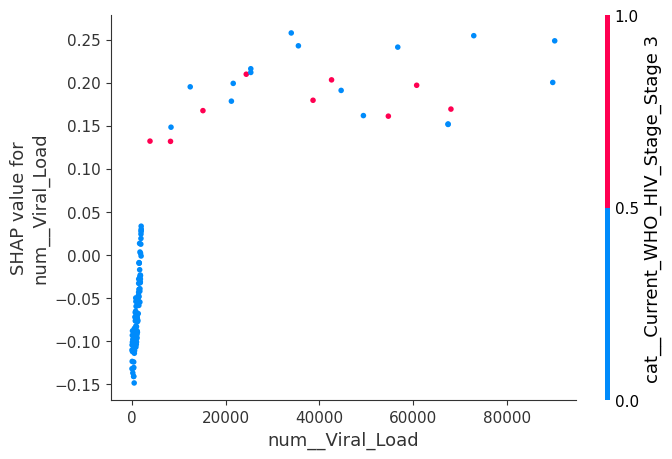

In [19]:
# 2. Viral load and WHO stage
shap.dependence_plot("num__Viral_Load", shap_values_class1, X_preprocessed, feature_names=feature_names, interaction_index="cat__Current_WHO_HIV_Stage_Stage 3")



Key Findings:
Low Viral Load Decreases Risk (Low SHAP): Clients with a very low Viral Load (near 0) show strongly negative SHAP values (down to -0.15). This means an undetectable or very low viral load is a powerful factor in decreasing the predicted risk of LFTU.

High Viral Load Increases Risk (High SHAP): As the Viral Load increases (above 20,000), the SHAP values shift to be strongly positive (up to 0.25). A high viral load is a strong indicator of increased predicted risk.

WHO Stage 3 Interaction (Color Dependence):The highest risk points (high positive SHAP values) are predominantly pink/red, indicating that clients in WHO HIV Clinical Stage 3 are at the highest predicted risk.

For clients with a high viral load (x-axis > 20,000), being in Stage 3 amplifies the risk contribution, leading to SHAP values up to 0.25. This shows the model correctly prioritizes a high viral load combined with advanced clinical progression as the most significant risk factor in this view.

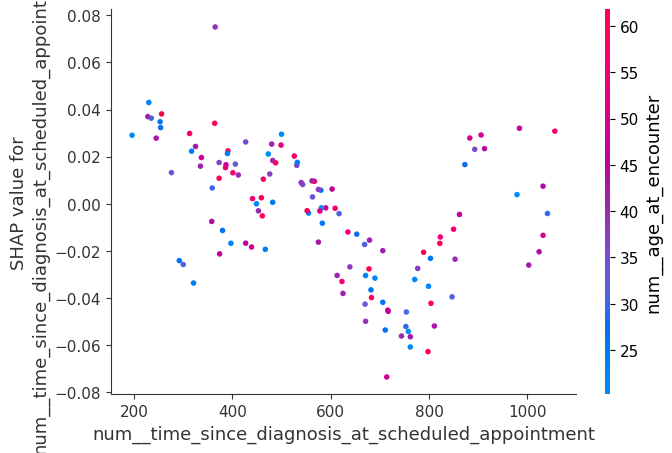

In [20]:

# 3. Time since diagnosis and age
shap.dependence_plot("num__time_since_diagnosis_at_scheduled_appointment", shap_values_class1, X_preprocessed, feature_names=feature_names, interaction_index="num__age_at_encounter")


As time_since_diagnosis increases (right side of plot), SHAP values generally decrease: This means longer time since diagnosis reduces the predicted risk ( of LTFU).

Color insight (age interaction):

Blue dots (younger patients) dominate the lower SHAP area at high time_since_diagnosis: Suggests younger patients who have lived longer with diagnosis contribute less to predicted risk (possibly more stable).
Older patients (red dots) appear more scattered across the higher SHAP range — model finds age interacts subtly here.

Clinical takeaway: Patients recently diagnosed (low time_since_diagnosis) tend to have a higher predicted risk (positive SHAP values), while those living longer with HIV are more stable — especially if younger.

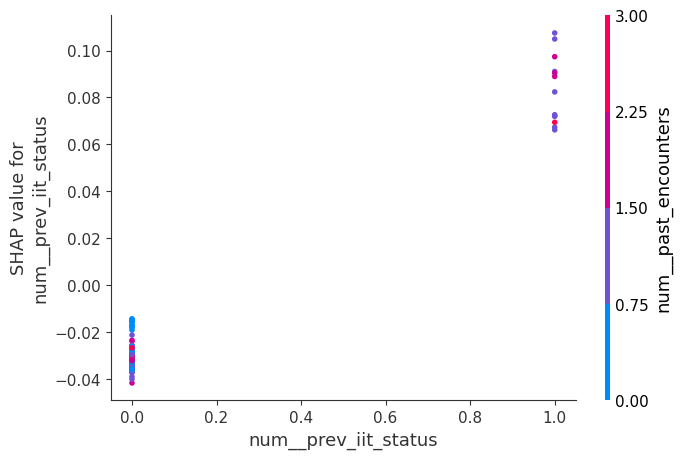

In [21]:

# 4. Previous IITs and past encounters
shap.dependence_plot("num__prev_iit_status", shap_values_class1, X_preprocessed, feature_names=feature_names, interaction_index="num__past_encounters")


The points on the right (x=1) correspond to patients with a previous IIT history: Their SHAP values are mostly positive, meaning this feature increases the predicted probability of dropout or instability.

Patients with no previous IIT (x=0) cluster near 0 or negative SHAP values, meaning it doesn’t strongly push predictions upward.

The color adds nuance:

Those with few past encounters (blue) have slightly higher SHAP values when prev_iit_status = 1: Suggests the combination of few visits + prior interruption amplifies the model’s risk prediction.

Clinical takeaway: Having a previous treatment interruption strongly increases predicted instability risk, especially for patients with few clinic encounters — a red flag for clinicians.

**Local Patient-Level Explainability**

1. Local Patient Level Explanation using Force Plot

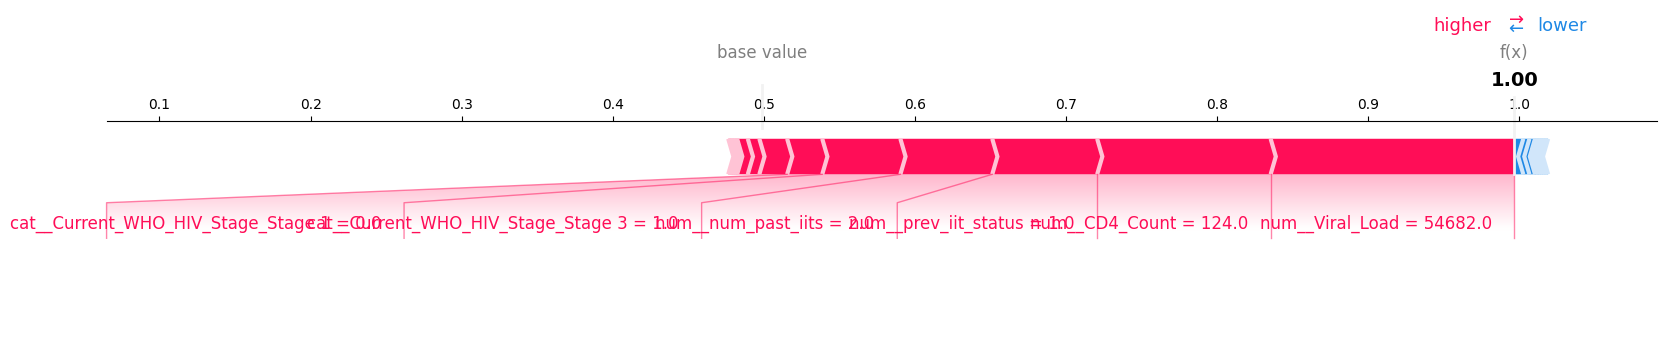

In [30]:

index = 10  # choose any patient index from test set

# Generate force plot for that instance
shap.initjs()
shap.force_plot(
    explainer.expected_value[1] if hasattr(explainer.expected_value, "__len__") else explainer.expected_value,  # base value for class 1
    shap_values_class1[index],        # SHAP values for that sample
    X_preprocessed[index],            # preprocessed feature values
    feature_names=feature_names,
    matplotlib=True
)

2. Local Explanation using Waterfall plot

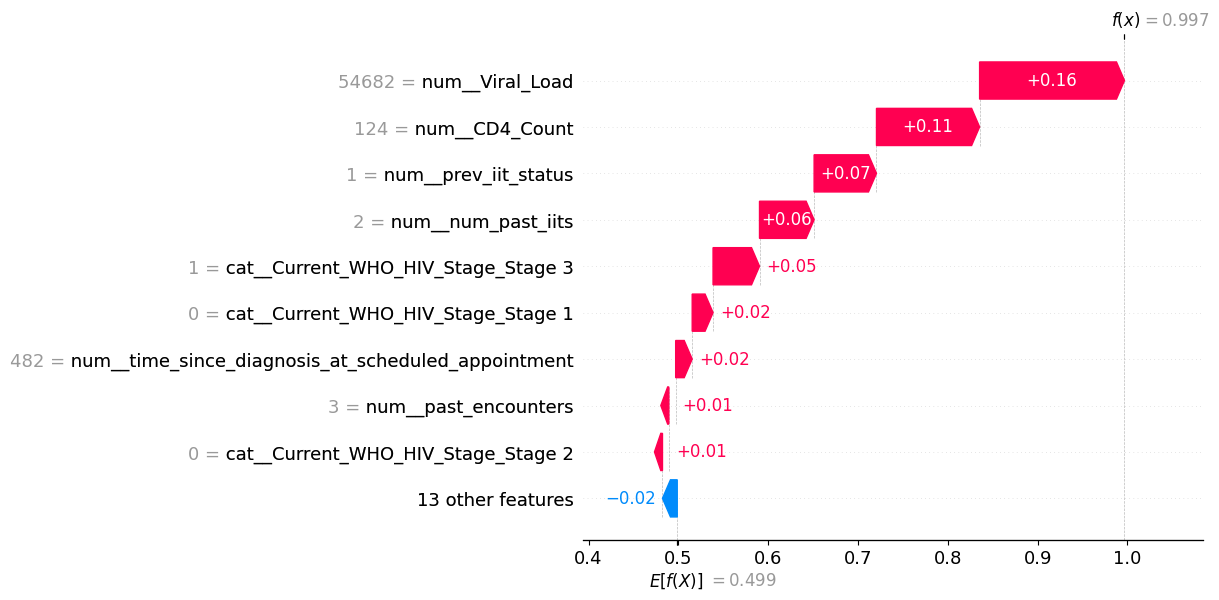

In [32]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_class1[index, :],
        base_values=explainer.expected_value[1] if hasattr(explainer.expected_value, "__len__") else explainer.expected_value,
        data=X_preprocessed[index, :],
        feature_names=feature_names
    )
)



Export to Sheets
Key Takeaway for Kasha
This plot clearly demonstrates that this specific client is flagged as high-risk primarily due to critical clinical and adherence failures:

Clinical Danger: High Viral Load and very low CD4 Count.

Behavioral Risk: A history of multiple treatment interruptions.

These factors together push the predicted risk to near certainty (f(x)≈1.0). For Kasha's Early Warning Systems, this client would be a top priority for immediate and intensive intervention (tele-counseling, local pharmacy follow-up, and clinical support) because the model has identified a perfect storm of clinical and behavioral danger signs.

**Cohort summary (average SHAP values per group)**

In [38]:
grouped = pd.DataFrame(shap_values_class1, columns=feature_names)
grouped["gender"] = X_test["gender"].values

grouped_summary = grouped.groupby("gender").mean().T.sort_values(by=["M", "F"], ascending=False)
grouped_summary.head(10)


gender,F,M
num__CD4_Count,0.009251,0.003712
num__past_encounters,-0.001038,0.003274
num__age_at_encounter,0.001088,0.001289
cat__Establishment_Clinic C,0.001713,0.001203
cat__Establishment_Clinic B,-0.000357,0.000891
cat__Establishment_Clinic A,0.000869,0.000784
cat__NCDs_Hypertension,0.002210,0.000655
cat__Current_WHO_HIV_Stage_Stage 1,-0.001460,0.000610
cat__NCDs_Diabetes,0.001248,0.000578
cat__TPT Outcome_Not Completed,0.000613,0.000194


### **Summary: Model Explainability Using SHAP**

To better understand how the model makes predictions for LTFU (Lost to Follow-Up), we used SHAP (SHapley Additive Explanations).
SHAP helps us quantify how much each feature (e.g., viral load, CD4 count, past interruptions) contributes to the model’s prediction — both globally (across all patients) and locally (for individual patients).

Global Explainability: Which Factors Drive LTFU Predictions Overall

The global SHAP summary and feature importance plots show that a few clinical and behavioral features have the largest influence on the model’s predictions:

Viral Load – Patients with high viral loads are much more likely to be predicted as lost to follow-up. This likely reflects poor adherence or disengagement from care leading to unsuppressed viral replication.

CD4 Count – Low CD4 counts are also strong indicators of LTFU risk, suggesting that patients with declining immune status may be less likely to remain consistently engaged in treatment.

Previous IIT (Interruption in Treatment) Status – Patients who have previously defaulted or interrupted ART are at significantly higher risk of being LTFU again.

Number of Past Interruptions – Repeated interruptions amplify the risk, showing a pattern of disengagement over time.

Time Since Diagnosis – Patients who were diagnosed more recently have slightly higher LTFU risk, possibly due to challenges in adjusting to care or stigma-related issues.

Other features, such as WHO HIV stage, age, and presence of comorbidities, contribute to predictions but to a smaller degree.

**Key Clinical takeaway*:

Patients with high viral loads, low CD4 counts, and a history of treatment interruptions are at the greatest risk of being lost to follow-up.
These patients should be prioritized for enhanced adherence counseling, community follow-up, and social support interventions.


**Local Explainability: Understanding Predictions for Individual Patients**

The waterfall plot breaks down how each feature pushes the prediction toward or away from LTFU.

For example, a patient with viral load = 54,682, CD4 count = 124, and previous IIT = 1 is predicted to be at high risk of LTFU.

Their high viral load (+0.16), low CD4 (+0.11), and prior interruptions (+0.07) are the main factors increasing their LTFU risk.

A few features, such as stable clinic engagement or being in an early WHO stage, may slightly reduce risk (negative SHAP values).


**Key Clinical takeaways*:

This local-level explanation enables clinicians to understand the specific reasons why a patient is flagged as high risk.
Instead of treating all high-risk patients the same, clinicians can target interventions to the underlying causes — for example:

Address poor viral suppression through medication review or adherence counseling

Schedule more frequent follow-up visits for those with repeated IITs

Offer extra psychosocial support for newly diagnosed patients